In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.3.2'
spark_version = 'spark-3.3.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,029 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:12 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,593 kB]
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:14 http://

In [105]:
 # Import packages
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark import SparkFiles
from pyspark.sql.types import StructType,StructField,StringType, DateType,IntegerType
import pandas as pd
from pathlib import Path
import sklearn as skl
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline
import matplotlib as plt
import tensorflow as tf


# Import the SMOTE OverSampler module form imbalanced-learn and Logistic Reegression for sklearn
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline
from collections import Counter
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [5]:
 # Read in raw data from github
url = "https://raw.githubusercontent.com/L-Nash/Project_4/main/Resources/diabetes_012_health_indicators_BRFSS2015.csv"
spark.sparkContext.addFile(url)
df_spark = spark.read.csv(SparkFiles.get("diabetes_012_health_indicators_BRFSS2015.csv"), header=True, inferSchema=True)

# Show DataFrame
df_spark.show()

+------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|Diabetes_012|HighBP|HighChol|CholCheck| BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex| Age|Education|Income|
+------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|         0.0|   1.0|     1.0|      1.0|40.0|   1.0|   0.0|                 0.0|         0.0|   0.0|    1.0|              0.0|          1.0|        0.0|    5.0|    18.0|    15.0|     1.0|0.0| 9.0|      4.0|   3.0|
|         0.0|   0.0|     0.0|      0.0|25.0|   1.0|   0.0|                 0.0|         1.0|   0.0|    0.0|              0.0|          0.0|    

In [6]:
# create a temporary view
df_spark.createOrReplaceTempView('diabetes')

# Transforming the Data with sparkSQL 

In [8]:
# SANDRA sql queries: start

In [51]:
# What is the distribution of diabetic status by AnyHealthcare status (No Access)

spark.sql('''
SELECT Diabetes_012 diabetic_status, 
count(AnyHealthcare) no_healthcare_access
FROM diabetes
WHERE AnyHealthcare = 0.0
GROUP BY 1
''').show()

+---------------+--------------------+
|diabetic_status|no_healthcare_access|
+---------------+--------------------+
|            0.0|               10741|
|            1.0|                 254|
|            2.0|                1422|
+---------------+--------------------+



In [52]:
# What is the distribution of diabetic status by AnyHealthcare status (Access)

spark.sql('''
SELECT Diabetes_012 diabetic_status, 
count(AnyHealthcare) healthcare_access
FROM diabetes
WHERE AnyHealthcare = 1.0
GROUP BY 1
''').show()

+---------------+-----------------+
|diabetic_status|healthcare_access|
+---------------+-----------------+
|            0.0|           202962|
|            1.0|             4377|
|            2.0|            33924|
+---------------+-----------------+



In [50]:
# What is the distribution of diabetic status (2.0 = Diabetic) by BMI

spark.sql('''
SELECT count(Diabetes_012) diabetic, 
BMI
FROM diabetes
WHERE Diabetes_012 = 2.0
GROUP BY 2
ORDER BY 2
''').show()

+--------+----+
|diabetic| BMI|
+--------+----+
|       2|13.0|
|       4|14.0|
|      12|15.0|
|      20|16.0|
|      48|17.0|
|      83|18.0|
|     135|19.0|
|     241|20.0|
|     479|21.0|
|     691|22.0|
|     913|23.0|
|    1469|24.0|
|    1451|25.0|
|    2002|26.0|
|    2757|27.0|
|    2251|28.0|
|    2231|29.0|
|    2322|30.0|
|    2112|31.0|
|    2120|32.0|
+--------+----+
only showing top 20 rows



In [49]:
# What is the distribution of diabetic status (1.0 = Pre-Diabetic) by BMI

spark.sql('''
SELECT count(Diabetes_012) pre_diabetic, 
BMI
FROM diabetes
WHERE Diabetes_012 = 1.0
GROUP BY 2
ORDER BY 2
''').show()

+------------+----+
|pre_diabetic| BMI|
+------------+----+
|           1|13.0|
|           1|14.0|
|           2|16.0|
|           9|17.0|
|          15|18.0|
|          38|19.0|
|          47|20.0|
|          75|21.0|
|         141|22.0|
|         156|23.0|
|         232|24.0|
|         235|25.0|
|         285|26.0|
|         426|27.0|
|         292|28.0|
|         288|29.0|
|         342|30.0|
|         272|31.0|
|         277|32.0|
|         234|33.0|
+------------+----+
only showing top 20 rows



In [48]:
# What is the distribution of diabetic status (0.0 = Not Diabetic) by BMI

spark.sql('''
SELECT count(Diabetes_012) not_diabetic, 
BMI
FROM diabetes
WHERE Diabetes_012 = 0.0
GROUP BY 2
ORDER BY 2
''').show()

+------------+----+
|not_diabetic| BMI|
+------------+----+
|           6|12.0|
|          18|13.0|
|          36|14.0|
|         120|15.0|
|         326|16.0|
|         719|17.0|
|        1705|18.0|
|        3795|19.0|
|        6039|20.0|
|        9301|21.0|
|       12811|22.0|
|       14541|23.0|
|       17849|24.0|
|       15460|25.0|
|       18275|26.0|
|       21423|27.0|
|       14002|28.0|
|       12371|29.0|
|       11909|30.0|
|        9891|31.0|
+------------+----+
only showing top 20 rows



In [47]:
# What is the distribution of diabetic status (2.0 = Diabetic) by Income Category

spark.sql('''
SELECT count(Diabetes_012) diabetic, 
Income
FROM diabetes
WHERE Diabetes_012 = 2.0
GROUP BY 2
ORDER BY 2
''').show()

+--------+------+
|diabetic|Income|
+--------+------+
|    2383|   1.0|
|    3086|   2.0|
|    3568|   3.0|
|    4054|   4.0|
|    4504|   5.0|
|    5291|   6.0|
|    5265|   7.0|
|    7195|   8.0|
+--------+------+



In [46]:
# What is the distribution of diabetic status (1.0 = Pre-Diabetic) by Income Category

spark.sql('''
SELECT count(Diabetes_012) pre_diabetic, 
Income
FROM diabetes
WHERE Diabetes_012 = 1.0
GROUP BY 2
ORDER BY 2
''').show()

+------------+------+
|pre_diabetic|Income|
+------------+------+
|         314|   1.0|
|         356|   2.0|
|         421|   3.0|
|         459|   4.0|
|         587|   5.0|
|         748|   6.0|
|         735|   7.0|
|        1011|   8.0|
+------------+------+



In [45]:
# What is the distribution of diabetic status (0.0 = Not Diabetic) by Income Category

spark.sql('''
SELECT count(Diabetes_012) not_diabetic, 
Income
FROM diabetes
WHERE Diabetes_012 = 0.0
GROUP BY 2
ORDER BY 2
''').show()

+------------+------+
|not_diabetic|Income|
+------------+------+
|        7114|   1.0|
|        8341|   2.0|
|       12005|   3.0|
|       15622|   4.0|
|       20792|   5.0|
|       30431|   6.0|
|       37219|   7.0|
|       82179|   8.0|
+------------+------+



In [44]:
# What is the distribution of diabetic status (2.0 = Diabetic) by Education Category

spark.sql('''
SELECT count(Diabetes_012) diabetic, 
Education
FROM diabetes
WHERE Diabetes_012 = 2.0
GROUP BY 2
ORDER BY 2
''').show()

+--------+---------+
|diabetic|Education|
+--------+---------+
|      47|      1.0|
|    1183|      2.0|
|    2296|      3.0|
|   11066|      4.0|
|   10354|      5.0|
|   10400|      6.0|
+--------+---------+



In [43]:
# What is the distribution of diabetic status (1.0 = Pre-Diabetic) by Education Category

spark.sql('''
SELECT count(Diabetes_012) pre_diabetic, 
Education
FROM diabetes
WHERE Diabetes_012 = 1.0
GROUP BY 2
ORDER BY 2
''').show()

+------------+---------+
|pre_diabetic|Education|
+------------+---------+
|           2|      1.0|
|         161|      2.0|
|         314|      3.0|
|        1350|      4.0|
|        1333|      5.0|
|        1471|      6.0|
+------------+---------+



In [42]:
# What is the distribution of diabetic status (0.0 = Not Diabetic) by Education Category

spark.sql('''
SELECT count(Diabetes_012) not_diabetic, 
Education
FROM diabetes
WHERE Diabetes_012 = 0.0
GROUP BY 2
ORDER BY 2
''').show()

+------------+---------+
|not_diabetic|Education|
+------------+---------+
|         125|      1.0|
|        2699|      2.0|
|        6868|      3.0|
|       50334|      4.0|
|       58223|      5.0|
|       95454|      6.0|
+------------+---------+



In [20]:
# SANDRA sql queries: end

In [24]:
# ISABELLA sql queries: start

In [41]:
# What is the distribution of diabetic status (2.0 = Diabetic) by Age Category

spark.sql('''
SELECT count(Diabetes_012) diabetic,
    Age 
FROM diabetes
WHERE Diabetes_012 == 2.0
GROUP BY 2
ORDER BY 2
''').show()

+--------+----+
|diabetic| Age|
+--------+----+
|      78| 1.0|
|     140| 2.0|
|     314| 3.0|
|     626| 4.0|
|    1051| 5.0|
|    1742| 6.0|
|    3088| 7.0|
|    4263| 8.0|
|    5733| 9.0|
|    6558|10.0|
|    5141|11.0|
|    3403|12.0|
|    3209|13.0|
+--------+----+



In [40]:
# What is the distribution of diabetic status (1.0 = Pre-Diabetic) by Age Category

spark.sql('''
SELECT count(Diabetes_012) pre_diabetic,
    Age 
FROM diabetes
WHERE Diabetes_012 == 1.0
GROUP BY 2
ORDER BY 2
''').show()

+------------+----+
|pre_diabetic| Age|
+------------+----+
|          21| 1.0|
|          54| 2.0|
|          72| 3.0|
|         142| 4.0|
|         163| 5.0|
|         312| 6.0|
|         418| 7.0|
|         550| 8.0|
|         702| 9.0|
|         697|10.0|
|         602|11.0|
|         445|12.0|
|         453|13.0|
+------------+----+



In [39]:
# What is the distribution of diabetic status (0.0 = Not Diabetic) by Age Category

spark.sql('''
SELECT count(Diabetes_012) not_diabetic,
    Age 
FROM diabetes
WHERE Diabetes_012 == 1.0
GROUP BY 2
ORDER BY 2
''').show()

+------------+----+
|not_diabetic| Age|
+------------+----+
|          21| 1.0|
|          54| 2.0|
|          72| 3.0|
|         142| 4.0|
|         163| 5.0|
|         312| 6.0|
|         418| 7.0|
|         550| 8.0|
|         702| 9.0|
|         697|10.0|
|         602|11.0|
|         445|12.0|
|         453|13.0|
+------------+----+



In [25]:
# ISABELLA sql queries: end

These SQL queries were guidelines for us to use when creating visualizations in Tableau.

# Transforming the Spark DataFrame to Pandas

In [199]:
# transform spark dataframe to pandas dataframe
pd_df = df_spark.toPandas()

In [56]:
# check dataframe
pd_df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


# Random Forest Model

In [ ]:
# Isabella: Random Forest Model

In [58]:
# Define features set
X = pd_df.copy()
X.drop("Diabetes_012", axis=1, inplace=True)

In [59]:
# Define target vector
y = pd_df["Diabetes_012"].ravel()
y[:5]

array([0., 0., 0., 0., 0.])

In [60]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [61]:
# Creating StandardScaler instance
scaler = StandardScaler()
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [62]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=1)
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [63]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [64]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1", "Actual 2"], columns=["Predicted 0", "Predicted 1",  "Predicted 2"]
)
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [65]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1,Predicted 2
Actual 0,51783,56,1589
Actual 1,1012,0,111
Actual 2,7184,3,1682


Accuracy Score : 0.8430305897193314
Classification Report
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     53428
         1.0       0.00      0.00      0.00      1123
         2.0       0.50      0.19      0.27      8869

    accuracy                           0.84     63420
   macro avg       0.45      0.39      0.40     63420
weighted avg       0.80      0.84      0.81     63420



In [66]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.18344591959161338, 'BMI'),
 (0.12184431239598932, 'Age'),
 (0.0985310997364313, 'Income'),
 (0.08402603439660714, 'PhysHlth'),
 (0.07073461983698508, 'Education'),
 (0.06905079351231164, 'GenHlth'),
 (0.06464525791495607, 'MentHlth'),
 (0.04118126704640851, 'HighBP'),
 (0.03397992775665969, 'Smoker'),
 (0.033812660976585335, 'Fruits'),
 (0.028459663554614118, 'Sex'),
 (0.02685276875875914, 'PhysActivity'),
 (0.02683461071645865, 'Veggies'),
 (0.026600138107161896, 'HighChol'),
 (0.022968814003758484, 'DiffWalk'),
 (0.018394325475478878, 'HeartDiseaseorAttack'),
 (0.015463967003883524, 'NoDocbcCost'),
 (0.012191255042965246, 'Stroke'),
 (0.009009344485394876, 'AnyHealthcare'),
 (0.008132418387650612, 'HvyAlcoholConsump'),
 (0.0038408012993271165, 'CholCheck')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

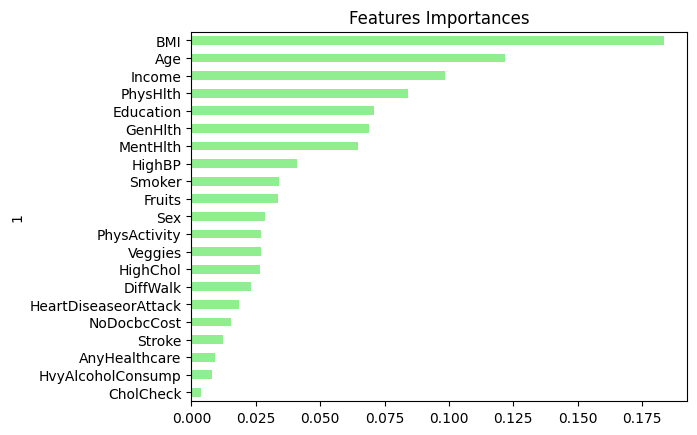

In [67]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

While this Random Forest Model was insightful in giving us the feature by importance, we felt we could create a better model using deep learning.

# Cleaning the DataFrame for Data Modeling

In [ ]:
# Isabella: Clean DataFrame for Data Modeling

In [68]:
# checking the columns
pd_df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [69]:
# renaming the Diabetes_012 column values
pd_df['Diabetes_012'] = pd_df['Diabetes_012'].replace([0.0,1,2],['no_diabetes','prediabetes', 'diabetes'])

In [70]:
# checking the df to see if our values were renamed
pd_df

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,no_diabetes,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,no_diabetes,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,no_diabetes,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,no_diabetes,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,no_diabetes,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,no_diabetes,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,diabetes,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,no_diabetes,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,no_diabetes,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


In [71]:
# using get dummies with the Diabetes_012 column
df_dummies = pd.get_dummies(pd_df["Diabetes_012"])

In [72]:
# checking if Diabetes_012 was encoded properly
df_dummies.head()

,diabetes,no_diabetes,prediabetes
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [73]:
# concatenating the dataframes and dropping the Diabetes_012 column
pd_df = pd.concat([pd_df, df_dummies], axis=1)
pd_df = pd_df.drop(columns="Diabetes_012")
# checking the dataframe
pd_df

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,diabetes,no_diabetes,prediabetes
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,18.0,15.0,1.0,0.0,9.0,4.0,3.0,0,1,0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.0,6.0,1.0,0,1,0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,30.0,30.0,1.0,0.0,9.0,4.0,8.0,0,1,0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,11.0,3.0,6.0,0,1,0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,3.0,0.0,0.0,0.0,11.0,5.0,4.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,5.0,0.0,1.0,5.0,6.0,7.0,0,1,0
253676,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,11.0,2.0,4.0,1,0,0
253677,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,2.0,5.0,2.0,0,1,0
253678,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,7.0,5.0,1.0,0,1,0


In [74]:
# renaming the Age column values
pd_df['Age'] = pd_df['Age'].replace([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,],
['18_24','25_29', '30_34', '35_39', '40_44', '45_49', '50_54', '55_59', '60_64', '65_69', '70_74', '75_79', '80+'])

In [75]:
# checking the df to see if our age values were renamed successfully
pd_df

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,diabetes,no_diabetes,prediabetes
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,18.0,15.0,1.0,0.0,60_64,4.0,3.0,0,1,0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,50_54,6.0,1.0,0,1,0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,30.0,30.0,1.0,0.0,60_64,4.0,8.0,0,1,0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,70_74,3.0,6.0,0,1,0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,3.0,0.0,0.0,0.0,70_74,5.0,4.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,5.0,0.0,1.0,40_44,6.0,7.0,0,1,0
253676,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,70_74,2.0,4.0,1,0,0
253677,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,25_29,5.0,2.0,0,1,0
253678,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,50_54,5.0,1.0,0,1,0


In [76]:
# using get_dummies on the Age column
age_dummies = pd.get_dummies(pd_df["Age"])

In [77]:
# checking the age_dummies columns
age_dummies.head()

,18_24,25_29,30_34,35_39,40_44,45_49,50_54,55_59,60_64,65_69,70_74,75_79,80+
0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0


In [78]:
# concatenating the dataframes and dropping the Age column
pd_df = pd.concat([pd_df, age_dummies], axis=1)
pd_df = pd_df.drop(columns="Age")
# checking df 
pd_df

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,35_39,40_44,45_49,50_54,55_59,60_64,65_69,70_74,75_79,80+
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,1,0,0,0,0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,1,0,0,0,0,0,0,0,0
253676,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
253677,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
253678,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,1,0,0,0,0,0,0


In [79]:
# renaming Education column values
pd_df['Education'] = pd_df['Education'].replace([1.0,2.0,3.0,4.0,5.0,6.0],
['no_school_pre_k','elementary', 'some_hs', 'hs_graduate', 'some_college_technical_school', 'college_graduate'])

In [80]:
# checking Education column to see if our values were successfully renamed
pd_df['Education']

0                           hs_graduate
1                      college_graduate
2                           hs_graduate
3                               some_hs
4         some_college_technical_school
                      ...              
253675                 college_graduate
253676                       elementary
253677    some_college_technical_school
253678    some_college_technical_school
253679                 college_graduate
Name: Education, Length: 253680, dtype: object

In [81]:
# using pd.get_dummies on the Education column
education_dummies = pd.get_dummies(pd_df["Education"])

In [82]:
# checking education_dummies df
education_dummies.head()

,college_graduate,elementary,hs_graduate,no_school_pre_k,some_college_technical_school,some_hs
0,0,0,1,0,0,0
1,1,0,0,0,0,0
2,0,0,1,0,0,0
3,0,0,0,0,0,1
4,0,0,0,0,1,0


In [83]:
# concatenating dataframes
pd_df = pd.concat([pd_df, education_dummies], axis=1)
pd_df = pd_df.drop(columns="Education")
# checking the df
pd_df

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,65_69,70_74,75_79,80+,college_graduate,elementary,hs_graduate,no_school_pre_k,some_college_technical_school,some_hs
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,1,0,0,0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0,1,0,0,0,0,0,0,0,1
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,1,0,0,0,0,0
253676,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
253677,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
253678,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0


In [84]:
# replacing income column values
pd_df['Income'] = pd_df['Income'].replace([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0],
['<$10,000','$10,000_<$15,000', '$15,000_<$20,000', '$20,000_<$25,000', '$25,000_<$35,000', '$35,000_<$50,000', '$50,000_<$75,000', '>$75,000'])

In [85]:
# checking income column values
pd_df['Income']

0         $15,000_<$20,000
1                 <$10,000
2                 >$75,000
3         $35,000_<$50,000
4         $20,000_<$25,000
                ...       
253675    $50,000_<$75,000
253676    $20,000_<$25,000
253677    $10,000_<$15,000
253678            <$10,000
253679    $10,000_<$15,000
Name: Income, Length: 253680, dtype: object

In [86]:
# using pd.get_dummies on Income
income_dummies = pd.get_dummies(pd_df["Income"])

In [87]:
# checking income
income_dummies.head()

,"$10,000_<$15,000","$15,000_<$20,000","$20,000_<$25,000","$25,000_<$35,000","$35,000_<$50,000","$50,000_<$75,000","<$10,000",">$75,000"
0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0


In [88]:
# concatenating dfs
pd_df = pd.concat([pd_df, income_dummies], axis=1)
pd_df = pd_df.drop(columns="Income")
# checking df
pd_df

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,some_college_technical_school,some_hs,"$10,000_<$15,000","$15,000_<$20,000","$20,000_<$25,000","$25,000_<$35,000","$35,000_<$50,000","$50,000_<$75,000","<$10,000",">$75,000"
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,1,0,0,0,0,0,0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0,1,0,0,0,0,1,0,0,0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
253676,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
253677,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,0,1,0,0,0,0,0,0,0
253678,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1,0,0,0,0,0,0,0,1,0


In [89]:
# final check of df column names
pd_df.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'diabetes', 'no_diabetes',
       'prediabetes', '18_24', '25_29', '30_34', '35_39', '40_44', '45_49',
       '50_54', '55_59', '60_64', '65_69', '70_74', '75_79', '80+',
       'college_graduate', 'elementary', 'hs_graduate', 'no_school_pre_k',
       'some_college_technical_school', 'some_hs', '$10,000_<$15,000',
       '$15,000_<$20,000', '$20,000_<$25,000', '$25,000_<$35,000',
       '$35,000_<$50,000', '$50,000_<$75,000', '<$10,000', '>$75,000'],
      dtype='object')

In [91]:
# Export our data to csv file
pd_df.to_csv('CleanedDiabetes.csv')

In [92]:
# Read in cleaned diabetes data from github
file_path = "https://raw.githubusercontent.com/L-Nash/Project_4/main/Resources/CleanedDiabetes.csv"
cleaned_df = pd.read_csv(file_path)

# Display diabetes data
cleaned_df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,some_college_technical_school,some_hs,"$10,000_<$15,000","$15,000_<$20,000","$20,000_<$25,000","$25,000_<$35,000","$35,000_<$50,000","$50,000_<$75,000","<$10,000",">$75,000"
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,1,0,0,0,0,0,0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0,1,0,0,0,0,1,0,0,0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1,0,0,0,1,0,0,0,0,0


# Over Sampling Classification

In [ ]:
# Sandra: over sampling data

In [93]:
# Separate the data into labels and features

# Separate the y variable, the labels
y=cleaned_df[["no_diabetes", "prediabetes","diabetes"]].values.reshape(-1,3)

# Separate the X variable, the features
X=cleaned_df.drop(columns=["diabetes", "no_diabetes", "prediabetes"],axis=1)

In [96]:
# Convert target variable 'y' to a 1-dimensional array using 'argmax' method

y_multi = np.array(y)
y = np.argmax(y_multi, axis=1)

In [97]:
# Split the data using train_test_split
# Assign a random_state to the function
X_train, X_test, y_train, y_test=train_test_split(X,y, random_state=48, stratify=y)

In [98]:
#Oversampling the data
oversample = SMOTE()

Class=0, n=160277 (33.333%)
Class=2, n=160277 (33.333%)
Class=1, n=160277 (33.333%)


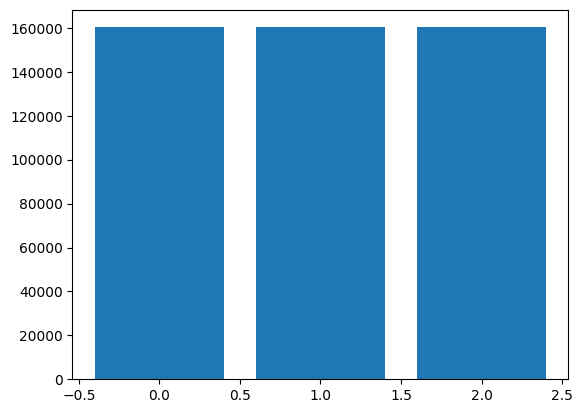

In [99]:
X_train, y_train = oversample.fit_resample(X_train, y_train)
# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
	per = v / len(y_train) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [100]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Logistic Regression Model Using Oversampled Data

In [ ]:
# Sandra: Logistic Regression Model using Oversampled Data

In [101]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
classifier = LogisticRegression(solver='liblinear',random_state=1,max_iter=100)

# Fit the model using the resampled training data
classifier.fit(X_train_scaled, y_train)

# Make a prediction using the testing data
lr_predictions= classifier.predict(X_test_scaled)

In [106]:
# Create and save the testing classification report
testing_report = classification_report(y_test, lr_predictions)

# Print the testing classification report
print(testing_report)

              precision    recall  f1-score   support

           0       0.90      0.89      0.89     53426
           1       0.00      0.00      0.00      1158
           2       0.39      0.48      0.43      8836

    accuracy                           0.81     63420
   macro avg       0.43      0.45      0.44     63420
weighted avg       0.81      0.81      0.81     63420



This model did not predict for pre-diabetes like we were hoping it would.

# Neural Network Model Using Oversampled Data

In [ ]:
# Isabella: Neural Network Model using Oversampled Data

In [107]:
# Create the Keras Sequential model
nn_model = tf.keras.models.Sequential()

In [108]:
# Add our first Dense layer, including the input layer
nn_model.add(tf.keras.layers.Dense(units=9, activation="relu", input_dim= len(X_train_scaled[0])))

In [109]:
nn_model.add(tf.keras.layers.Dense(units=7, activation="relu"))
nn_model.add(tf.keras.layers.Dense(units=5, activation="relu"))
nn_model.add(tf.keras.layers.Dense(units=3, activation="relu"))
nn_model.add(tf.keras.layers.Dense(units=1, activation="relu"))

# Add the output layer that uses a probability activation function
nn_model.add(tf.keras.layers.Dense(units=3, activation="softmax"))

In [77]:
# Check the structure of the Sequential model
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 414       
                                                                 
 dense_1 (Dense)             (None, 7)                 70        
                                                                 
 dense_2 (Dense)             (None, 5)                 40        
                                                                 
 dense_3 (Dense)             (None, 3)                 18        
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
 dense_5 (Dense)             (None, 3)                 6         
                                                                 
Total params: 552
Trainable params: 552
Non-trainable pa

In [110]:
# Compile the Sequential model together and customize metrics
nn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model to the training data
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=10)

Epoch 1/10
15026/15026 [==============================] - 44s 3ms/step - loss: 0.6927 - accuracy: 0.6624
Epoch 2/10
15026/15026 [==============================] - 42s 3ms/step - loss: 0.6376 - accuracy: 0.6953
Epoch 3/10
15026/15026 [==============================] - 38s 2ms/step - loss: 0.6317 - accuracy: 0.6998
Epoch 4/10
15026/15026 [==============================] - 39s 3ms/step - loss: 0.6265 - accuracy: 0.7026
Epoch 5/10
15026/15026 [==============================] - 38s 2ms/step - loss: 0.6161 - accuracy: 0.7069
Epoch 6/10
15026/15026 [==============================] - 38s 3ms/step - loss: 0.6118 - accuracy: 0.7088
Epoch 7/10
15026/15026 [==============================] - 38s 3ms/step - loss: 0.6070 - accuracy: 0.7111
Epoch 8/10
15026/15026 [==============================] - 38s 3ms/step - loss: 0.6023 - accuracy: 0.7130
Epoch 9/10
15026/15026 [==============================] - 42s 3ms/step - loss: 0.5999 - accuracy: 0.7140
Epoch 10/10
15026/15026 [==============================

<Axes: >

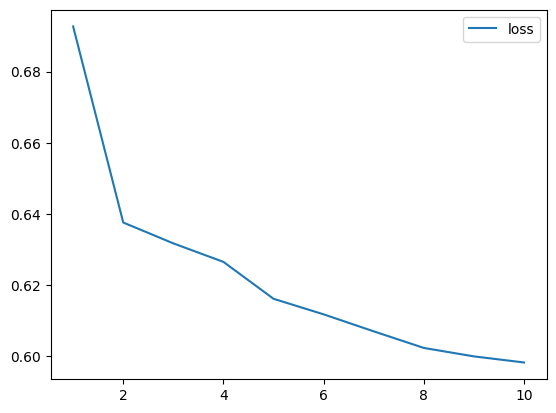

In [111]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")

<Axes: >

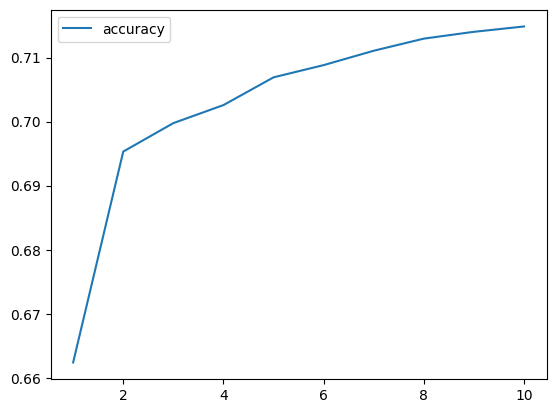

In [112]:
# Plot the accuracy
history_df.plot(y="accuracy")

In [113]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1982/1982 - 3s - loss: 0.4572 - accuracy: 0.8189 - 3s/epoch - 1ms/step
Loss: 0.4572441875934601, Accuracy: 0.8188583850860596


In [114]:
# Making predictions using the testing data
predictions = nn_model.predict(X_test_scaled)
print(predictions)

1982/1982 [==============================] - 3s 2ms/step
[[0.86932    0.02767635 0.10300374]
 [0.82499325 0.03765368 0.13735296]
 [0.9776938  0.00432789 0.01797837]
 ...
 [0.8617091  0.02937626 0.10891458]
 [0.14313695 0.21403189 0.64283115]
 [0.3670563  0.1496713  0.4832723 ]]


In [115]:
pred_test = np.argmax(predictions, axis=1)
print(pred_test)

[0 0 0 ... 0 2 2]


In [140]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, pred_test)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1", "Actual 2"], columns=["Predicted 0", "Predicted 1",  "Predicted 2"]
)
# Calculating the accuracy score
acc_score = accuracy_score(y_test, pred_test)

print(cm_df)
print('-'*40)
print(f"Accuracy Score: {acc_score}")
print('-'*40)
print(classification_report(y_test, pred_test))

          Predicted 0  Predicted 1  Predicted 2
Actual 0        48879            0         4547
Actual 1          902            0          256
Actual 2         5783            0         3053
----------------------------------------
Accuracy Score: 0.8188584042888679
----------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.91      0.90     53426
           1       0.00      0.00      0.00      1158
           2       0.39      0.35      0.37      8836

    accuracy                           0.82     63420
   macro avg       0.42      0.42      0.42     63420
weighted avg       0.80      0.82      0.81     63420



Using resampled data did not get the results we were hoping for. Since we cannot predict for pre-diabetes, we decided to remove pre-diabetes from our target and add it to our features.

# Automated Neural Network Model Without Prediabetes as a Target

In [ ]:
# Isabella: Automated Neural Network Model without Prediabetes as a Target

In [141]:
# checking the df columns
pd_df.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'diabetes', 'no_diabetes',
       'prediabetes', '18_24', '25_29', '30_34', '35_39', '40_44', '45_49',
       '50_54', '55_59', '60_64', '65_69', '70_74', '75_79', '80+',
       'college_graduate', 'elementary', 'hs_graduate', 'no_school_pre_k',
       'some_college_technical_school', 'some_hs', '$10,000_<$15,000',
       '$15,000_<$20,000', '$20,000_<$25,000', '$25,000_<$35,000',
       '$35,000_<$50,000', '$50,000_<$75,000', '<$10,000', '>$75,000'],
      dtype='object')

In [143]:
# Define features set
X = pd_df.copy()
X.drop(["diabetes", "no_diabetes"],axis=1,inplace=True)

In [144]:
# checking X shape
X.shape

(253680, 46)

In [146]:
# Define target vector
y = pd_df[['no_diabetes','diabetes']].values.reshape(-1,2)

In [147]:
# checking y shape
y.shape

(253680, 2)

In [148]:
# Use sklearn to split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [149]:
# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [150]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid', 'softmax'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=10,
        step=2), activation=activation, input_dim=len(X_train_scaled[0])))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=2, activation="softmax"))

    # Compile the model
    nn_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [152]:
# install keras tuner for google colab
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 7.6 MB/s eta 0:00:00


In [153]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    overwrite=True,
    hyperband_iterations=2)

In [154]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 60 Complete [00h 07m 24s]
val_accuracy: 0.8601545095443726

Best val_accuracy So Far: 0.8681173324584961
Total elapsed time: 02h 49m 59s


In [155]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'sigmoid',
 'first_units': 3,
 'num_layers': 1,
 'units_0': 7,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0012',
 'units_1': 3,
 'units_2': 5,
 'units_3': 7,
 'units_4': 7,
 'units_5': 9}

In [177]:
best_model = tuner.get_best_models(1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 141       
                                                                 
 dense_1 (Dense)             (None, 7)                 28        
                                                                 
 dense_2 (Dense)             (None, 2)                 16        
                                                                 
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


In [156]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1982/1982 - 3s - loss: 0.3110 - accuracy: 0.8681 - 3s/epoch - 1ms/step
Loss: 0.31097307801246643, Accuracy: 0.8681173324584961


# Neural Network Model using Best Hyperparameters

In [ ]:
# Isabella: NN Model using Best Hyperparameters

In [157]:
pd_df.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'diabetes', 'no_diabetes',
       'prediabetes', '18_24', '25_29', '30_34', '35_39', '40_44', '45_49',
       '50_54', '55_59', '60_64', '65_69', '70_74', '75_79', '80+',
       'college_graduate', 'elementary', 'hs_graduate', 'no_school_pre_k',
       'some_college_technical_school', 'some_hs', '$10,000_<$15,000',
       '$15,000_<$20,000', '$20,000_<$25,000', '$25,000_<$35,000',
       '$35,000_<$50,000', '$50,000_<$75,000', '<$10,000', '>$75,000'],
      dtype='object')

In [158]:
# Define features set
X = pd_df.copy()
X.drop(["diabetes", "no_diabetes"],axis=1,inplace=True)

In [159]:
X.shape

(253680, 46)

In [160]:
# Define target vector
y = pd_df[['no_diabetes','diabetes']].values.reshape(-1,2)

In [161]:
y.shape

(253680, 2)

In [162]:
# Use sklearn to split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [163]:
# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [165]:
# Create the Keras Sequential model
nn_model_2 = tf.keras.models.Sequential()

In [166]:
# Add our first Dense layer, including the input layer
nn_model_2.add(tf.keras.layers.Dense(units=3, activation="sigmoid", input_dim= len(X_train_scaled[0])))

In [167]:
nn_model_2.add(tf.keras.layers.Dense(units=7, activation="sigmoid"))
nn_model_2.add(tf.keras.layers.Dense(units=3, activation="sigmoid"))
nn_model_2.add(tf.keras.layers.Dense(units=5, activation="sigmoid"))
nn_model_2.add(tf.keras.layers.Dense(units=7, activation="sigmoid"))
nn_model_2.add(tf.keras.layers.Dense(units=7, activation="sigmoid"))
nn_model_2.add(tf.keras.layers.Dense(units=9, activation="sigmoid"))

# Add the output layer that uses a probability activation function
nn_model_2.add(tf.keras.layers.Dense(units=2, activation="softmax"))

In [168]:
# Check the structure of the Sequential model
nn_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 3)                 141       
                                                                 
 dense_4 (Dense)             (None, 7)                 28        
                                                                 
 dense_5 (Dense)             (None, 3)                 24        
                                                                 
 dense_6 (Dense)             (None, 5)                 20        
                                                                 
 dense_7 (Dense)             (None, 7)                 42        
                                                                 
 dense_8 (Dense)             (None, 7)                 56        
                                                                 
 dense_9 (Dense)             (None, 9)                

In [169]:
# Compile the Sequential model together and customize metrics
nn_model_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model to the training data
fit_model = nn_model_2.fit(X_train_scaled, y_train, epochs=7)

Epoch 1/7
5946/5946 [==============================] - 23s 3ms/step - loss: 0.3508 - accuracy: 0.8608
Epoch 2/7
5946/5946 [==============================] - 28s 5ms/step - loss: 0.3217 - accuracy: 0.8608
Epoch 3/7
5946/5946 [==============================] - 19s 3ms/step - loss: 0.3156 - accuracy: 0.8596
Epoch 4/7
5946/5946 [==============================] - 19s 3ms/step - loss: 0.3139 - accuracy: 0.8554
Epoch 5/7
5946/5946 [==============================] - 18s 3ms/step - loss: 0.3128 - accuracy: 0.8539
Epoch 6/7
5946/5946 [==============================] - 18s 3ms/step - loss: 0.3117 - accuracy: 0.8577
Epoch 7/7
5946/5946 [==============================] - 20s 3ms/step - loss: 0.3122 - accuracy: 0.8583


<Axes: >

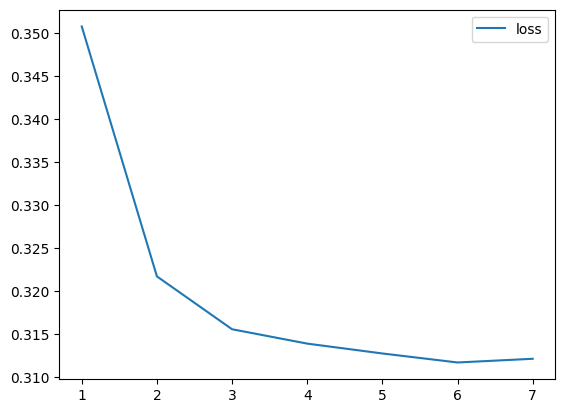

In [170]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")

<Axes: >

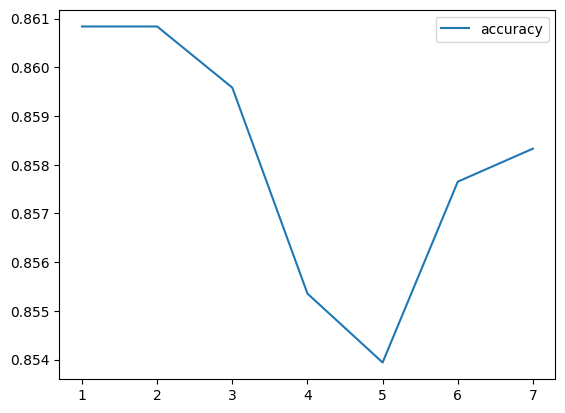

In [171]:
# Plot the accuracy
history_df.plot(y="accuracy")

In [173]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1982/1982 - 6s - loss: 0.3134 - accuracy: 0.8450 - 6s/epoch - 3ms/step
Loss: 0.31335780024528503, Accuracy: 0.8449857831001282


Using the best hyper parameters to create a neural network model did not result in the accuracy I was hoping for. I think using the 'best model' of the keras tuner will result in better accuracy and loss.

# Neural Network Model using Best Model

In [ ]:
# Isabella: NN Model using Best Model

In [178]:
# Define features set
X = pd_df.copy()
X.drop(["diabetes", "no_diabetes"],axis=1,inplace=True)

In [180]:
# Define target vector
y = pd_df[['no_diabetes','diabetes']].values.reshape(-1,2)

In [181]:
# Use sklearn to split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [182]:
# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [183]:
# Create the Keras Sequential model
nn_best_model = tf.keras.models.Sequential()

In [184]:
# Add our first Dense layer, including the input layer
nn_best_model.add(tf.keras.layers.Dense(units=3, activation="sigmoid", input_dim= len(X_train_scaled[0])))

In [185]:
nn_best_model.add(tf.keras.layers.Dense(units=7, activation="sigmoid"))

# Add the output layer that uses a probability activation function
nn_best_model.add(tf.keras.layers.Dense(units=2, activation="softmax"))

In [186]:
# checking the model is the same as the "best model"
nn_best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 3)                 141       
                                                                 
 dense_4 (Dense)             (None, 7)                 28        
                                                                 
 dense_5 (Dense)             (None, 2)                 16        
                                                                 
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


In [187]:
# Compile the Sequential model together and customize metrics
nn_best_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model to the training data
fit_model = nn_best_model.fit(X_train_scaled, y_train, epochs=7)

Epoch 1/7
5946/5946 [==============================] - 21s 3ms/step - loss: 0.3481 - accuracy: 0.8482
Epoch 2/7
5946/5946 [==============================] - 14s 2ms/step - loss: 0.3124 - accuracy: 0.8610
Epoch 3/7
5946/5946 [==============================] - 15s 2ms/step - loss: 0.3106 - accuracy: 0.8641
Epoch 4/7
5946/5946 [==============================] - 14s 2ms/step - loss: 0.3094 - accuracy: 0.8676
Epoch 5/7
5946/5946 [==============================] - 14s 2ms/step - loss: 0.3090 - accuracy: 0.8675
Epoch 6/7
5946/5946 [==============================] - 14s 2ms/step - loss: 0.3087 - accuracy: 0.8676
Epoch 7/7
5946/5946 [==============================] - 13s 2ms/step - loss: 0.3085 - accuracy: 0.8678


<Axes: >

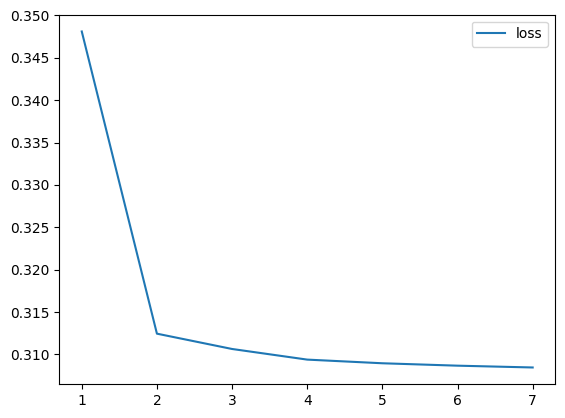

In [188]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")

<Axes: >

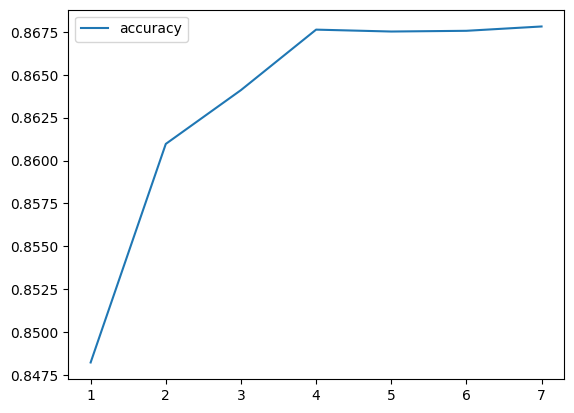

In [189]:
# Plot the accuracy
history_df.plot(y="accuracy")

In [191]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1982/1982 - 5s - loss: 0.3102 - accuracy: 0.8666 - 5s/epoch - 2ms/step
Loss: 0.310181587934494, Accuracy: 0.8665562868118286


In [193]:
# Making predictions using the testing data
predictions = nn_best_model.predict(X_test_scaled)
print(predictions)

1982/1982 [==============================] - 4s 2ms/step
[[0.960303   0.03969697]
 [0.97489583 0.02510414]
 [0.85818875 0.14181122]
 ...
 [0.520661   0.47933894]
 [0.71797764 0.28202236]
 [0.9281933  0.07180677]]


In [194]:
pred_test = np.argmax(predictions, axis=1)
print(pred_test)

[0 0 0 ... 0 0 0]


In [195]:
y_test_pred = np.argmax(y_test, axis=1)
print(y_test_pred)

[0 1 0 ... 0 1 0]


In [197]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test_pred, pred_test)
cm_df = pd.DataFrame(
    cm, index=["Actual 0 (no_diabetes)", "Actual 1 (diabetes)"], columns=["Predicted 0 (no_diabetes)", "Predicted 1 (diabetes)"]
)
# Calculating the accuracy score
acc_score = accuracy_score(y_test_pred, pred_test)

print(cm_df)
print('-'*40)
print(f"Accuracy Score: {acc_score}")
print('-'*40)
print(classification_report(y_test_pred, pred_test))

                        Predicted 0 (no_diabetes)  Predicted 1 (diabetes)
Actual 0 (no_diabetes)                      53132                    1419
Actual 1 (diabetes)                          7044                    1825
----------------------------------------
Accuracy Score: 0.8665562913907284
----------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.97      0.93     54551
           1       0.56      0.21      0.30      8869

    accuracy                           0.87     63420
   macro avg       0.72      0.59      0.61     63420
weighted avg       0.84      0.87      0.84     63420



Unfortunately, there was not a big enough sample for people with pre diabetes to be able to predict for it. Using "diabetes" and "no diabetes" as targets and adding "pre diabetes" to the features resulted in getting our best model. 